# Project Overview

<b>Competition Description from Kaggle:</b>

Think back to your favorite teacher. They motivated and inspired you to learn. And they knew your strengths and weaknesses. The lessons they taught were based on your ability. For example, teachers would make sure you understood algebra before advancing to calculus. Yet, many students don’t have access to personalized learning. In a world full of information, data scientists like you can help. Machine learning can offer a path to success for young people around the world, and you are invited to be part of this mission.



In 2018, 260 million children weren't attending school. At the same time, more than half of these young students didn't meet minimum reading and math standards. Education was already in a tough place when COVID-19 forced most countries to temporarily close schools. This further delayed learning opportunities and intellectual development. The equity gaps in every country could grow wider. We need to re-think the current education system in terms of attendance, engagement, and individualized attention.

Riiid Labs, an AI solutions provider delivering creative disruption to the education market, empowers global education players to rethink traditional ways of learning leveraging AI. With a strong belief in equal opportunity in education, Riiid launched an AI tutor based on deep-learning algorithms in 2017 that attracted more than one million South Korean students. This year, the company released EdNet, the world’s largest open database for AI education containing more than 100 million student interactions.

In this competition, your challenge is to create algorithms for "Knowledge Tracing," the modeling of student knowledge over time. The goal is to accurately predict how students will perform on future interactions. You will pair your machine learning skills using Riiid’s EdNet data.

Your innovative algorithms will help tackle global challenges in education. If successful, it’s possible that any student with an Internet connection can enjoy the benefits of a personalized learning experience, regardless of where they live. With your participation, we can build a better and more equitable model for education in a post-COVID-19 world.

<b>Elevator Pitch</b>

The goal of this project is to predict how students will perform on future interactions with an AI tutor developed at Riiid Labs. AI solutions can change the current education system in terms of attendance, engagement, and individualized attention. It's especially relevant now in times of COVID as many schools have shutdown and switched to remote learning. If successful, AI could provide more equal opportunity in education to anyone with an internet connection. My model should help predict and guide the success of the AI tutor. I will be doing analytics on past student performance and predict if the student will get future questions right, wrong, or leave it blank.

8 features
- timestamp                         int64
- user_id                           int64
- content_id                        int64
- content_type_id                   int64
- task_container_id                 int64
- user_answer                       int64
- prior_question_elapsed_time       float64
- prior_question_had_explanation    object

1 target
- answered_correctly                int64
- -1(did not answer), 0 (answered incorrectly), 1(answered correctly)

# Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import zipfile
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from dask.distributed import Client, LocalCluster
import joblib

In [2]:
cluster = LocalCluster()
client = Client(cluster) # start a local Dask client

In [3]:
cluster

# Data

#### Import Data

In [4]:
# Connect to the PostgreSQL database riiid_education we created previously
# Note: Run create SQL database notebook if database not created
DBNAME = "riiid_education"
conn = psycopg2.connect(dbname=DBNAME)
cursor = conn.cursor()

In [5]:
#create a list of the table names
cursor.execute("""SELECT table_name FROM information_schema.tables
       WHERE table_schema = 'public'""")
tables = []
for table in cursor.fetchall():
    tables.append(table[0])
tables

['train', 'questions', 'lectures', 'example_test']

In [6]:
train = pd.read_csv('../../data/train.csv')
# train = pd.read_sql("""SELECT * 
# FROM train;""", conn)
questions = pd.read_sql("SELECT * FROM questions;", conn)
lectures = pd.read_sql("SELECT * FROM lectures;", conn)

### Explore Data

In [7]:
train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,NaN
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


<b>Description of Features in Train</b>

`row_id` - ID for the row.

`timestamp` - the time between this user interaction and the first event from that user.

`user_id` - ID for the user.

`content_id` - ID for the user interaction

`content_type_id` - 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture. Every row with 1 has an answered_correctly value of not answered(-1). Filtering out all rows with content id 1 filters out all the unanswered questions. This is the culprit of our 100% predictions on unanswered.

`task_container_id` - Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a task_container_id. Monotonically increasing for each user.

`user_answer` - the user's answer to the question, if any. Read -1 as null, for lectures.

`answered_correctly` - if the user responded correctly. Read -1 as null, for lectures.

`prior_question_elapsed_time` - How long it took a user to answer their previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Note that the time is the total time a user took to solve all the questions in the previous bundle.

`prior_question_had_explanation` - Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.

In [8]:
train.shape
# 101,230,332 rows

(101230332, 10)

In [9]:
# Find number of unique values in each column
print("Count of unique values in each column")
for column in train.columns:
    print(f"{column}: {train[column].nunique()}")

Count of unique values in each column
row_id: 101230332
timestamp: 72821015
user_id: 393656
content_id: 13782
content_type_id: 2
task_container_id: 10000
user_answer: 5
answered_correctly: 3
prior_question_elapsed_time: 3258
prior_question_had_explanation: 2


In [10]:
# Drop all rows with answered_correctly is blank (-1)
train = train[train.content_type_id != 1]

Categorical Features: `content_type_id`, `user_answer`, `answered_correctly`, `prior_question_had_explanation`

In [11]:
questions.head()

,question,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38 ...
1,1,1,1,1,131 36 81 ...
2,2,2,0,1,131 101 162 92 ...
3,3,3,0,1,131 149 162 29 ...
4,4,4,3,1,131 5 162 38 ...


<b>Description of Features in Questions</b>

`question` - foreign key for the train/test content_id column, when the content type is question (0).

`bundle_id` - code for which questions are served together.

`correct_answer` - the answer to the question. Can be compared with the train user_answer column to check if the user was right.

`part` - top level category code for the question.

`tags` - one or more detailed tag codes for the question. The meaning of the tags will not be provided, but these codes are sufficient for clustering the questions together.

In [12]:
questions.shape

(13523, 5)

In [13]:
# Find number of unique values in each column
print("Count of unique values in each column")
for column in questions.columns:
    print(f"{column}: {questions[column].nunique()}")

Count of unique values in each column
question: 13523
bundle_id: 9765
correct_answer: 4
part: 7
tags: 1519


Categorical Features: `correct_answer`, `part`

Note - Should only need bundle_id and part column. If i use tag column, will need to split the tags to a feature each

In [14]:
lectures.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


<b>Description of Features in Questions</b>

`lecture_id` - foreign key for the train/test content_id column, when the content type is lecture (1).

`part` - top level category code for the lecture.

`tag` - one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.

`type_of` - brief description of the core purpose of the lecture

In [15]:
# Find number of unique values in each column
print("Count of unique values in each column")
for column in lectures.columns:
    print(f"{column}: {lectures[column].nunique()}")

Count of unique values in each column
lecture_id: 418
tag: 151
part: 7
type_of: 4


#### Merge train and questions tables

In [16]:
df = train.merge(questions, left_on='content_id', right_on='question', how='left')

In [17]:
df.drop(['tags', 'question', 'row_id', 'user_answer'], axis=1, inplace=True)

In [18]:
df.columns

Index(['timestamp', 'user_id', 'content_id', 'content_type_id',
       'task_container_id', 'answered_correctly',
       'prior_question_elapsed_time', 'prior_question_had_explanation',
       'bundle_id', 'correct_answer', 'part'],
      dtype='object')

In [19]:
# Getting a 100k sample of my data to work with cause mo data mo problems
df_sample = df.sample(n=100000, random_state=42)

In [20]:
# Split data into features and target
X = df_sample.drop('answered_correctly', axis=1)
y = df_sample['answered_correctly']

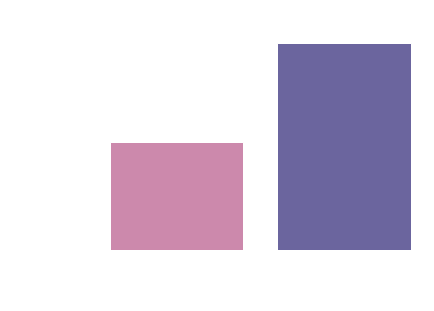

In [21]:
# # Class Imbalance
sns.set(context = 'notebook',  style = 'white')
fig, ax = plt.subplots(figsize = (6,4)) 
ax = sns.countplot(y, palette = ['#d77ead', '#645ca7'])
ax.axes.set_title("Class Distribution",fontsize=28, color='white')
ax.set_xlabel("Answers",fontsize=22, color='white', labelpad=10)
ax.set_ylabel("Count",fontsize=22, color='white', labelpad=10)
ax.set_xticklabels(['Incorrect', "Correct"], fontsize=15, color='white')
ax.set_yticklabels(['0', '10,000', '20,000', '30,000', '40,000', '50,000', '60,000'], fontsize=15, color='white')
ax.grid(color='white', axis='y')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig('../../reports/figures/class_imbalance_ppt.png', bbox_inches='tight', transparent=True);

### Prepare data for modeling

In [22]:
# Train Test Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [23]:
# Pipeline for preprocessing numeric features
# numeric_features = list(X.select_dtypes(exclude='object').columns)
numeric_features = ['timestamp', 'user_id', 'content_id', 'task_container_id', 'prior_question_elapsed_time', 'bundle_id']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Pipeline for preprocessing categorical features
# categorical_features = list(X.select_dtypes(include='object').columns)
categorical_features = ['part', 'content_type_id', 'prior_question_had_explanation', 'correct_answer']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(fill_value='None')),
    ('one_hot_encoder', OneHotEncoder(sparse=False))])

# Pipeline for preprocessing combined
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [24]:
# Use preprocessing pipeline to transform the data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Modeling

#### First Simple Model

In [25]:
# Logistic Regression Model Fit
fsm = LogisticRegression()
fsm.fit(X_train_transformed, y_train)

LogisticRegression()

In [26]:
# Score on our training data
y_pred = fsm.predict(X_train_transformed)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.06      0.11     24105
           1       0.66      0.97      0.79     45895

    accuracy                           0.66     70000
   macro avg       0.61      0.52      0.45     70000
weighted avg       0.63      0.66      0.56     70000



In [27]:
# Score on our testing data
y_pred = fsm.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.06      0.12     10224
           1       0.67      0.97      0.79     19776

    accuracy                           0.66     30000
   macro avg       0.62      0.52      0.45     30000
weighted avg       0.63      0.66      0.56     30000



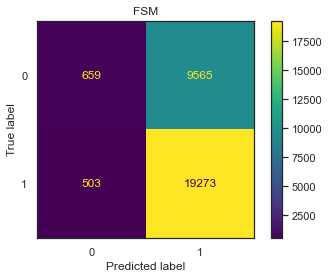

In [28]:
# Confusion matrix
sns.set(context = 'notebook', style = 'white')
plot_confusion_matrix(fsm, X_test_transformed, y_test)
plt.title('FSM');

We are severely underpredicting incorrectly answered. Our recall is a mere .12. This is due to class imbalance - there are much more correctly answered questions than incorrect. Let's resample the data the adress this issue

### Further Data Preprocessing

#### Using Smote to Deal with Class Imbalance

In [29]:
print("Before OverSampling, counts of label -1: {}".format(sum(y_train == -1))) 
print("Before OverSampling, counts of label 0: {}".format(sum(y_train == 0))) 
print("Before OverSampling, counts of label 1: {} \n".format(sum(y_train == 1))) 

with joblib.parallel_backend('dask'):
    # import SMOTE module from imblearn library 
    # pip install imblearn (if you don't have imblearn in your system) 
    sm = SMOTE(random_state = 42) 
    X_train_res, y_train_res = sm.fit_sample(X_train_transformed, y_train.ravel()) 

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 

print("After OverSampling, counts of label -1: {}".format(sum(y_train_res == -1))) 
print("After OverSampling, counts of label 0".format(sum(y_train_res == 0))) 
print("After OverSampling, counts of label 1: {}".format(sum(y_train_res == 1)))

Before OverSampling, counts of label -1: 0
Before OverSampling, counts of label 0: 24105
Before OverSampling, counts of label 1: 45895 

After OverSampling, the shape of train_X: (91790, 21)
After OverSampling, the shape of train_y: (91790,) 

After OverSampling, counts of label -1: 0
After OverSampling, counts of label 0
After OverSampling, counts of label 1: 45895


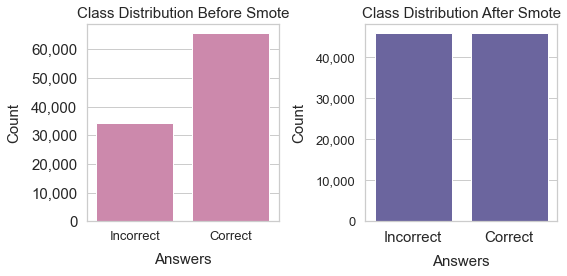

In [99]:
sns.set(context = 'notebook', style = 'whitegrid')

fig, axes = plt.subplots(1, 2, figsize = (8,4)) 
ax = sns.countplot(y, palette = ['#d77ead', '#d77ead'], ax=axes[0])
ax.set_title("Class Distribution Before Smote",fontsize=15)
ax.set_xlabel("Answers",fontsize=15, labelpad=10)
ax.set_ylabel("Count",fontsize=15,  labelpad=10)
ax.set_xticklabels(['Incorrect', "Correct"], fontsize=13)
ax.set_yticklabels(['0', '10,000', '20,000', '30,000', '40,000', '50,000', '60,000'], fontsize=15)

ax2 = sns.countplot(y_train_res, palette = ['#645ca7', '#645ca7'], ax=axes[1])
ax2.set_title("Class Distribution After Smote",fontsize=15)
ax2.set_xlabel("Answers",fontsize=15, labelpad=10)
ax2.set_ylabel("Count",fontsize=15,  labelpad=10)
ax2.set_xticklabels(['Incorrect', "Correct"], fontsize=15)
ax2.set_yticklabels(['0', '10,000', '20,000', '30,000', '40,000', '50,000', '60,000'], fontsize=13)

# fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,4)) 
# ax1.hist(y, color = 'red', alpha = .5, bins = 5)
# ax1.set_title('Class distribution before SMOTE')
# ax2.hist(y_train_res, color = 'blue', alpha = .5, bins = 5)
# ax2.set_title('Class distribution After SMOTE')
fig.tight_layout()
# plt.savefig('../../reports/figures/Fixing_class_imbalance.jpg', bbox_inches='tight');

#### Simple Linear Regression Model After Smote

In [31]:
# X_train_res, y_train_res, X_test_transformed, y_test
simple_lr = LogisticRegression()
with joblib.parallel_backend('dask'):
    simple_lr.fit(X_train_res, y_train_res)

In [32]:
# Score on our training data
y_pred = simple_lr.predict(X_train_res)
print(classification_report(y_train_res, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.54      0.55     45895
           1       0.56      0.58      0.57     45895

    accuracy                           0.56     91790
   macro avg       0.56      0.56      0.56     91790
weighted avg       0.56      0.56      0.56     91790



In [33]:
# Score on testing data
y_pred = simple_lr.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.40      0.55      0.46     10224
           1       0.71      0.58      0.64     19776

    accuracy                           0.57     30000
   macro avg       0.56      0.56      0.55     30000
weighted avg       0.61      0.57      0.58     30000



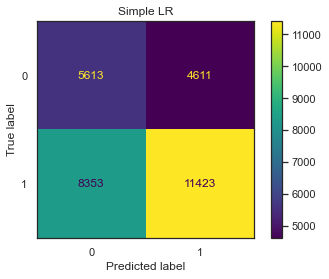

In [34]:
# Confusion matrix
sns.set(context = 'notebook', style = 'white')
plot_confusion_matrix(simple_lr, X_test_transformed, y_test)
plt.title('Simple LR');

In [35]:
# # Grid Search for best params for Logistic Regression Classifier
# params = {
#     'penalty':['l1', 'l2', 'elasticnet'],        # l1 is Lasso, l2 is Ridge
#     'solver':['liblinear', 'saga'],
#     'C': [.0001, .001,.1, 1, 10],
#     'verbose': [0, 1],
#     'max_iter': [10, 100, 1000],
#     'tol': [1, 10, 100, 1000]
# }
# lr_gs = GridSearchCV(LogisticRegression(random_state=42), params, cv=3)
# with joblib.parallel_backend('dask'):
#     lr_gs.fit(X_train_res, y_train_res)

# print("Best Params", lr_gs.best_params_)
# print("Best Score", lr_gs.best_score_)
# # Best Params {'C': 0.001, 'max_iter': 10, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 1, 'verbose': 0}
# # Best Score 0.6904251320938254

In [36]:
# Plug in best params and run model
lr_best = LogisticRegression(random_state=42, penalty= 'l2', solver= 'liblinear', C=.001, verbose=0, max_iter=10, tol=1)
lr_best.fit(X_train_res, y_train_res)

LogisticRegression(C=0.001, max_iter=10, random_state=42, solver='liblinear',
                   tol=1)

In [37]:
# Score on our training data
y_pred = lr_best.predict(X_train_res)
print(classification_report(y_train_res, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.53      0.54     45895
           1       0.55      0.58      0.57     45895

    accuracy                           0.56     91790
   macro avg       0.56      0.56      0.56     91790
weighted avg       0.56      0.56      0.56     91790



In [38]:
# Score on testing data
y_pred = lr_best.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.40      0.54      0.46     10224
           1       0.71      0.58      0.64     19776

    accuracy                           0.57     30000
   macro avg       0.56      0.56      0.55     30000
weighted avg       0.61      0.57      0.58     30000



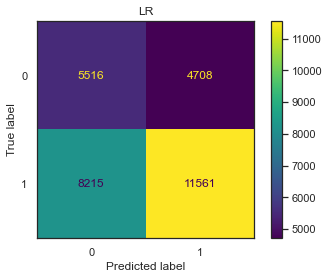

In [39]:
# Confusion matrix
plot_confusion_matrix(lr_best, X_test_transformed, y_test)
plt.title('LR');

#### K Nearest Neighbors

In [40]:
# # Grid Search for best params for KNN Classifier *Do this overnight, takes forever*
# params = {
#     'n_neighbors': [3, 5, 7],
#     'weights': ['uniform', 'distance'],
#     'p' : [1,2]
# }

# knn_gs = GridSearchCV(KNeighborsClassifier(), params)
# with joblib.parallel_backend('dask'):
#     knn_gs.fit(X_train_res, y_train_res)

# print("Best Params", knn_gs.best_params_)

In [41]:
# Plug in best params and run model
knn_best = KNeighborsClassifier()
knn_best.fit(X_train_res, y_train_res)

KNeighborsClassifier()

In [42]:
# Score on our training data
y_pred = knn_best.predict(X_train_res)
print(classification_report(y_train_res, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.87      0.80     45895
           1       0.84      0.69      0.76     45895

    accuracy                           0.78     91790
   macro avg       0.79      0.78      0.78     91790
weighted avg       0.79      0.78      0.78     91790



In [43]:
# Score on testing data
y_pred = knn_best.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.37      0.49      0.42     10224
           1       0.68      0.56      0.61     19776

    accuracy                           0.54     30000
   macro avg       0.52      0.52      0.52     30000
weighted avg       0.57      0.54      0.55     30000



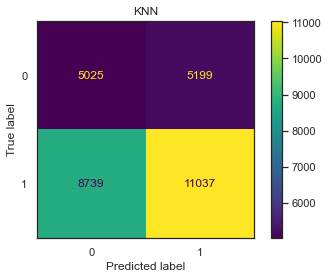

In [44]:
# Confusion matrix
plot_confusion_matrix(knn_best, X_test_transformed, y_test)
plt.title('KNN');

#### Random Forest

In [45]:
# # Grid Search for best params for Random Forest Classifier
# params = {
#     'max_depth': [20],
#     'n_estimators': [700, 800]
# }

# rf_gs = GridSearchCV(RandomForestClassifier(random_state=42), params)
# with joblib.parallel_backend('dask'):
#     rf_gs.fit(X_train_res, y_train_res)

# print("Best Params", rf_gs.best_params_)

Best Params {'max_depth': 20, 'n_estimators': 700}


In [93]:
# Plug in best params and run model
rf_best = RandomForestClassifier(max_depth=20, n_estimators=800, random_state=42)
with joblib.parallel_backend('dask'):
    rf_best.fit(X_train_res, y_train_res)

In [94]:
# Score on our training data
y_pred = rf_best.predict(X_train_res)
print(classification_report(y_train_res, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     45895
           1       0.98      0.91      0.94     45895

    accuracy                           0.94     91790
   macro avg       0.94      0.94      0.94     91790
weighted avg       0.94      0.94      0.94     91790



In [95]:
# Score on testing data
y_pred = rf_best.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.41      0.46      0.43     10224
           1       0.70      0.66      0.68     19776

    accuracy                           0.59     30000
   macro avg       0.56      0.56      0.56     30000
weighted avg       0.60      0.59      0.60     30000



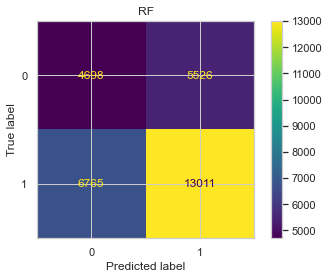

In [96]:
# Confusion matrix
plot_confusion_matrix(rf_best, X_test_transformed, y_test)
plt.title('RF');

#### Support Vector Machines

This is a slow one

In [50]:
# # Instantiate SVC
# svc = SVC(cache_size=500, random_state=42)
# with joblib.parallel_backend('dask'):
#     svc.fit(X_train_res, y_train_res)

In [51]:
# # Score on our training data
# y_pred = svc.predict(X_train_res)
# print(classification_report(y_train_res, y_pred))

In [52]:
# # Score on testing data
# y_pred = svc.predict(X_test_transformed)
# print(classification_report(y_test, y_pred))

In [53]:
# # Confusion matrix
# plot_confusion_matrix(svc, X_test_transformed, y_test)
# plt.title('SVC');

#### AdaBoost

In [54]:
# Instantiate an AdaBoostClassifier
# Defaults are estimator=DecisionTree, n_estimator=100, learning_rate = 1
adaboost = AdaBoostClassifier(random_state=42)
adaboost.fit(X_train_res, y_train_res)

AdaBoostClassifier(random_state=42)

In [55]:
# Score on our training data
y_pred = adaboost.predict(X_train_res)
print(classification_report(y_train_res, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.56      0.57     45895
           1       0.58      0.60      0.59     45895

    accuracy                           0.58     91790
   macro avg       0.58      0.58      0.58     91790
weighted avg       0.58      0.58      0.58     91790



In [56]:
# Score on testing data
y_pred = adaboost.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.40      0.52      0.46     10224
           1       0.71      0.60      0.65     19776

    accuracy                           0.58     30000
   macro avg       0.56      0.56      0.55     30000
weighted avg       0.61      0.58      0.59     30000



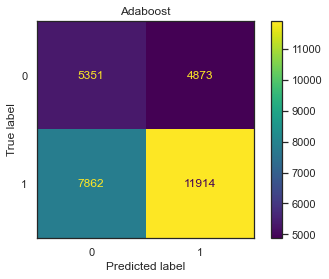

In [57]:
# Confusion matrix
plot_confusion_matrix(adaboost, X_test_transformed, y_test)
plt.title('Adaboost');

#### Extreme Gradient Boosting

In [58]:
# Instantiate XGBClassifier
# We dont specify an estimator since Gradient Boosting uses regression trees
# Default params: n_estimators=100, learning_rate=0.1, mex_depth=3, min_samples_split, min_samples_leaf, max_features
# In Gradient Boosting, it is recommended to use all the features
# XGB Optomized for distributed computing. Parallel training.
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train_res, y_train_res)

XGBClassifier(random_state=42)

In [59]:
# Score on our training data
y_pred = xgb.predict(X_train_res)
print(classification_report(y_train_res, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.59      0.61     45895
           1       0.61      0.66      0.64     45895

    accuracy                           0.62     91790
   macro avg       0.62      0.62      0.62     91790
weighted avg       0.62      0.62      0.62     91790



In [60]:
# Score on testing data
y_pred = xgb.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.41      0.47      0.44     10224
           1       0.71      0.66      0.68     19776

    accuracy                           0.59     30000
   macro avg       0.56      0.56      0.56     30000
weighted avg       0.61      0.59      0.60     30000



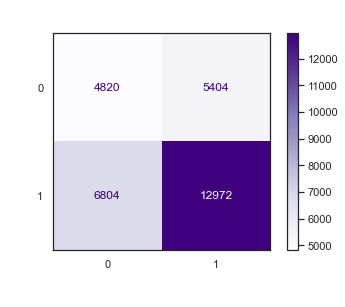

In [61]:
# Confusion matrix
ax = plot_confusion_matrix(xgb, X_test_transformed, y_test, cmap = "Purples", )
plt.title('XGB', fontsize=28, color='white')
plt.xlabel("Predicted Label",fontsize=22, color='white', labelpad=10)
plt.ylabel("True Label",fontsize=22, color='white', labelpad=10)
plt.savefig('../../reports/figures/matrix_ppt.png', bbox_inches='tight', transparent=True);

#### Light Gradient Boosting

In [62]:
# Params similar to gradient boosting except default max_depth = -1 (unlimited)
lgb = LGBMClassifier(seed=42)
lgb.fit(X_train_res, y_train_res)

LGBMClassifier(seed=42)

In [63]:
# Score on our training data
y_pred = lgb.predict(X_train_res)
print(classification_report(y_train_res, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.59      0.65     45895
           1       0.65      0.78      0.71     45895

    accuracy                           0.68     91790
   macro avg       0.69      0.68      0.68     91790
weighted avg       0.69      0.68      0.68     91790



In [64]:
# Score on testing data
y_pred = lgb.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.43      0.35      0.38     10224
           1       0.69      0.76      0.73     19776

    accuracy                           0.62     30000
   macro avg       0.56      0.55      0.55     30000
weighted avg       0.60      0.62      0.61     30000



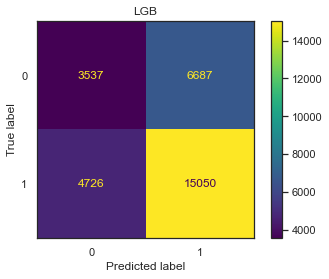

In [65]:
# Confusion matrix
plot_confusion_matrix(lgb, X_test_transformed, y_test)
plt.title('LGB');

#### Neural Networks